## Lab1

This project aims to provide hands-on experience with fundamental classification algorithms in machine learning. By implementing **Logistic Regression** and **Support Vector Machine (SVM)** using gradient descent, and building a **Multilayer Perceptron (MLP)** with PyTorch, we explore the practical aspects of model training, hyperparameter tuning, and performance evaluation. The final goal is to conduct an empirical comparison of these methods on real-world datasets, analyzing their accuracy, convergence behavior, and computational efficiency.  

---

#### **Dataset and Methodology**  
- **Dataset**: Real-world data with features stored in `X` files and labels in `Y` files.  
- **Preprocessing**:  
  - Standardize features using `StandardScaler`.  
  - Strict separation of training and test sets.  
- **Models**:  
  - **Logistic Regression**: Cross-entropy loss with SGD optimization.  
  - **SVM**: Hinge loss with L2 regularization.  
  - **MLP**: 1 hidden layer (128 neurons), ReLU activation, CrossEntropyLoss.  
- **Evaluation Metrics**:  
  - Classification accuracy (training/test).  
  - Training time (seconds).  
  - Loss convergence curves.  

In [9]:
## Import related packages and perform data preprocessing
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time

def preprocess_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

### 1 Logistic regression with gradient descent method

In [10]:
## Logistic regression with gradient descent method
class LogisticRegression:
    def __init__(self, lr=0.01, max_iter=1000, tol=1e-4):
        self.lr = lr          # learning rate
        self.max_iter = max_iter  
        self.tol = tol        
        self.weights = None   # model weights
        self.loss_history = []  # record loss
        self.train_accuracies = []  # record train accuracy
        self.test_accuracies = []   # record test accuracy

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y, X_test, y_test):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.loss_history = []
        self.train_accuracies = []
        self.test_accuracies = []

        for epoch in range(self.max_iter):
            linear_model = np.dot(X, self.weights)
            y_pred = self.sigmoid(linear_model)

            # loss calculation -- crossentropy
            loss = -np.mean(y * np.log(y_pred + 1e-9) + (1 - y) * np.log(1 - y_pred + 1e-9))
            self.loss_history.append(loss)

            # gradient calculation
            gradient = np.dot(X.T, (y_pred - y)) / n_samples
            prev_weights = np.copy(self.weights)
            self.weights -= self.lr * gradient  # update weights

            # index calculation
            train_acc = accuracy_score(y, (y_pred >= 0.5).astype(int))
            test_acc = accuracy_score(y_test, (self.sigmoid(np.dot(X_test, self.weights)) >= 0.5).astype(int))
            self.train_accuracies.append(train_acc)
            self.test_accuracies.append(test_acc)

            # stop condition
            if np.linalg.norm(self.weights - prev_weights) < self.tol:
                break

            # print train process
            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

    def predict(self, X):
        linear_model = np.dot(X, self.weights)
        y_pred = self.sigmoid(linear_model)
        return (y_pred >= 0.5).astype(int)

### 2 Support Vector Machine with gradient descent method

In [11]:
## Support Vector Machine with gradient descent method
class SVM:
    def __init__(self, lr=0.001, lambda_param=0.01, max_iter=1000):
        self.lr = lr              # learning rate
        self.lambda_param = lambda_param  # normalization
        self.max_iter = max_iter
        self.weights = None
        self.bias = 0
        self.loss_history = []  # record loss
        self.train_accuracies = []  # record train accuracy
        self.test_accuracies = []   # record test accuracy

    def hinge_loss(self, X, y):
        distances = 1 - y * (np.dot(X, self.weights) + self.bias)
        distances[distances < 0] = 0  # Hinge Loss
        return self.lambda_param * np.dot(self.weights, self.weights) + np.mean(distances)

    def fit(self, X, y, X_test, y_test):
        y = np.where(y == 0, -1, 1)  # label transformation 
        y_test_svm = np.where(y_test == 0, -1, 1)
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        self.loss_history = []
        self.train_accuracies = []
        self.test_accuracies = []

        for epoch in range(self.max_iter):
            gradient_weights = 2 * self.lambda_param * self.weights
            gradient_bias = 0

            for idx in range(n_samples):
                xi = X[idx]
                yi = y[idx]
                condition = yi * (np.dot(xi, self.weights) + self.bias) >= 1
                if not condition:
                    gradient_weights -= yi * xi
                    gradient_bias -= yi

            # gradient average
            gradient_weights /= n_samples
            gradient_bias /= n_samples

            # update params
            self.weights -= self.lr * gradient_weights
            self.bias -= self.lr * gradient_bias

            # loss calculation
            loss = self.hinge_loss(X, y)
            self.loss_history.append(loss)

            # index calculation
            y_pred_train = np.sign(np.dot(X, self.weights) + self.bias)
            y_pred_test = np.sign(np.dot(X_test, self.weights) + self.bias)
            train_acc = accuracy_score(y, y_pred_train)
            test_acc = accuracy_score(y_test_svm, y_pred_test)
            self.train_accuracies.append(train_acc)
            self.test_accuracies.append(test_acc)

            # print train process
            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

    def predict(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        return np.where(linear_output >= 0, 1, 0)  # label transform

### 3 MLP using PyTorch

In [12]:
## MLP using Pytorch
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)


In [13]:
## train mlp model
def train_mlp(X_train, y_train, X_test, y_test, input_size, hidden_size, output_size, num_epochs=100, learning_rate=0.001):
    # data transformation
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

    # model, criterion and optimizer
    model = MLP(input_size, hidden_size, output_size)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # index record
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    # train
    start_time = time.time()
    for epoch in range(num_epochs):
        # forward
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss record
        train_losses.append(loss.item())

        # accuracy calculation
        with torch.no_grad():
            y_pred_train = model(X_train_tensor)
            y_pred_train_cls = (y_pred_train >= 0.5).float()
            train_accuracy = accuracy_score(y_train_tensor, y_pred_train_cls)
            train_accuracies.append(train_accuracy)

            y_pred_test = model(X_test_tensor)
            y_pred_test_cls = (y_pred_test >= 0.5).float()
            test_accuracy = accuracy_score(y_test_tensor, y_pred_test_cls)
            test_accuracies.append(test_accuracy)

        # print train process
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}')

    end_time = time.time()
    print(f'MLP Training Time: {end_time - start_time} seconds')

    return {
        'train_acc': train_accuracies[-1],
        'test_acc': test_accuracies[-1],
        'train_time': end_time - start_time,
        'loss_history': train_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies
    }

### 4 A Comparitive Study

In [14]:
## define main workflow to simplize user operation
def main():
    # load data
    try:
        X_train = pd.read_csv('X_train.csv')
        y_train = pd.read_csv('Y_train.csv')
        X_test = pd.read_csv('X_test.csv')
        y_test = pd.read_csv('Y_test.csv')
    except Exception as e:
        print(f"Error loading data: {e}")
        return

    # data preprocess
    X_train_scaled, X_test_scaled = preprocess_data(X_train, X_test)

    # params
    input_size = X_train_scaled.shape[1]
    hidden_size = 64
    output_size = 1
    num_epochs = 100
    learning_rate = 0.001

    # logistic regression
    lr_model = LogisticRegression(lr=0.1, max_iter=5000)
    start_time_lr = time.time()
    lr_model.fit(X_train_scaled, y_train.values.ravel(), X_test_scaled, y_test.values.ravel())
    end_time_lr = time.time()
    print(f'Logistic Regression Training Time: {end_time_lr - start_time_lr} seconds')
    y_pred_lr = lr_model.predict(X_test_scaled)
    accuracy_lr = accuracy_score(y_test, y_pred_lr)
    print(f"Logistic Regression Test Accuracy: {accuracy_lr:.4f}")

    # SVM
    svm_model = SVM(lr=0.001, lambda_param=0.01, max_iter=1000)
    start_time_svm = time.time()
    svm_model.fit(X_train_scaled, y_train.values.ravel(), X_test_scaled, y_test.values.ravel())
    end_time_svm = time.time()
    print(f'SVM Training Time: {end_time_svm - start_time_svm} seconds')
    y_pred_svm = svm_model.predict(X_test_scaled)
    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    print(f"SVM Test Accuracy: {accuracy_svm:.4f}")

    # MLP
    mlp_results = train_mlp(
        X_train_scaled, y_train, X_test_scaled, y_test,
        input_size, hidden_size, output_size,
        num_epochs, learning_rate
    )

    # plot loss-accuracy graph
    plt.figure(figsize=(15, 10))

    # logistic regression
    plt.subplot(3, 2, 1)
    plt.plot(lr_model.loss_history, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Logistic Regression Loss')
    plt.legend()

    plt.subplot(3, 2, 2)
    plt.plot(lr_model.train_accuracies, label='Train Accuracy')
    plt.plot(lr_model.test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Logistic Regression Accuracy')
    plt.legend()

    # SVM
    plt.subplot(3, 2, 3)
    plt.plot(svm_model.loss_history, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('SVM Loss')
    plt.legend()

    plt.subplot(3, 2, 4)
    plt.plot(svm_model.train_accuracies, label='Train Accuracy')
    plt.plot(svm_model.test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('SVM Accuracy')
    plt.legend()

    # MLP
    plt.subplot(3, 2, 5)
    plt.plot(mlp_results['loss_history'], label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('MLP Loss')
    plt.legend()

    plt.subplot(3, 2, 6)
    plt.plot(mlp_results['train_accuracies'], label='Train Accuracy')
    plt.plot(mlp_results['test_accuracies'], label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('MLP Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('all_models_comparison.png')
    plt.show()

    # comparison
    models = ['Logistic Regression', 'SVM', 'MLP']
    test_accuracies = [accuracy_lr, accuracy_svm, mlp_results['test_acc']]
    training_times = [end_time_lr - start_time_lr, end_time_svm - start_time_svm, mlp_results['train_time']]

    # comparison plot
    fig, ax1 = plt.subplots(figsize=(10, 6))

    x = np.arange(len(models))
    width = 0.35

    ax1.bar(x - width/2, test_accuracies, width, label='Test Accuracy')
    ax1.set_xlabel('Models')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Model Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models)
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    ax2.bar(x + width/2, training_times, width, label='Training Time (seconds)', color='orange')
    ax2.set_ylabel('Training Time (seconds)')
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()

    print("\nModel Comparison:")
    print(f"{'Model':<20} {'Test Accuracy':<15} {'Training Time (s)':<20}")
    print(f"{'-'*20} {'-'*15} {'-'*20}")
    print(f"{'Logistic Regression':<20} {accuracy_lr:.4f} {' ' * 5} {end_time_lr - start_time_lr:.2f}")
    print(f"{'SVM':<20} {accuracy_svm:.4f} {' ' * 5} {end_time_svm - start_time_svm:.2f}")
    print(f"{'MLP':<20} {mlp_results['test_acc']:.4f} {' ' * 5} {mlp_results['train_time']:.2f}")


start training below $\downarrow$

Epoch 0, Loss: 0.6931, Train Acc: 0.4316, Test Acc: 0.9524
Epoch 100, Loss: 0.1088, Train Acc: 0.9737, Test Acc: 0.9841
Epoch 200, Loss: 0.0922, Train Acc: 0.9816, Test Acc: 0.9894
Epoch 300, Loss: 0.0850, Train Acc: 0.9816, Test Acc: 0.9894
Epoch 400, Loss: 0.0808, Train Acc: 0.9816, Test Acc: 0.9894
Epoch 500, Loss: 0.0780, Train Acc: 0.9816, Test Acc: 0.9894
Epoch 600, Loss: 0.0759, Train Acc: 0.9816, Test Acc: 0.9894
Epoch 700, Loss: 0.0743, Train Acc: 0.9816, Test Acc: 0.9894
Epoch 800, Loss: 0.0730, Train Acc: 0.9816, Test Acc: 0.9894
Epoch 900, Loss: 0.0719, Train Acc: 0.9816, Test Acc: 0.9841
Epoch 1000, Loss: 0.0709, Train Acc: 0.9816, Test Acc: 0.9841
Epoch 1100, Loss: 0.0701, Train Acc: 0.9816, Test Acc: 0.9841
Epoch 1200, Loss: 0.0694, Train Acc: 0.9842, Test Acc: 0.9841
Epoch 1300, Loss: 0.0688, Train Acc: 0.9842, Test Acc: 0.9841
Epoch 1400, Loss: 0.0682, Train Acc: 0.9842, Test Acc: 0.9841
Epoch 1500, Loss: 0.0677, Train Acc: 0.9842, Test Acc: 0.9841
Epoch 1600, Loss: 0.

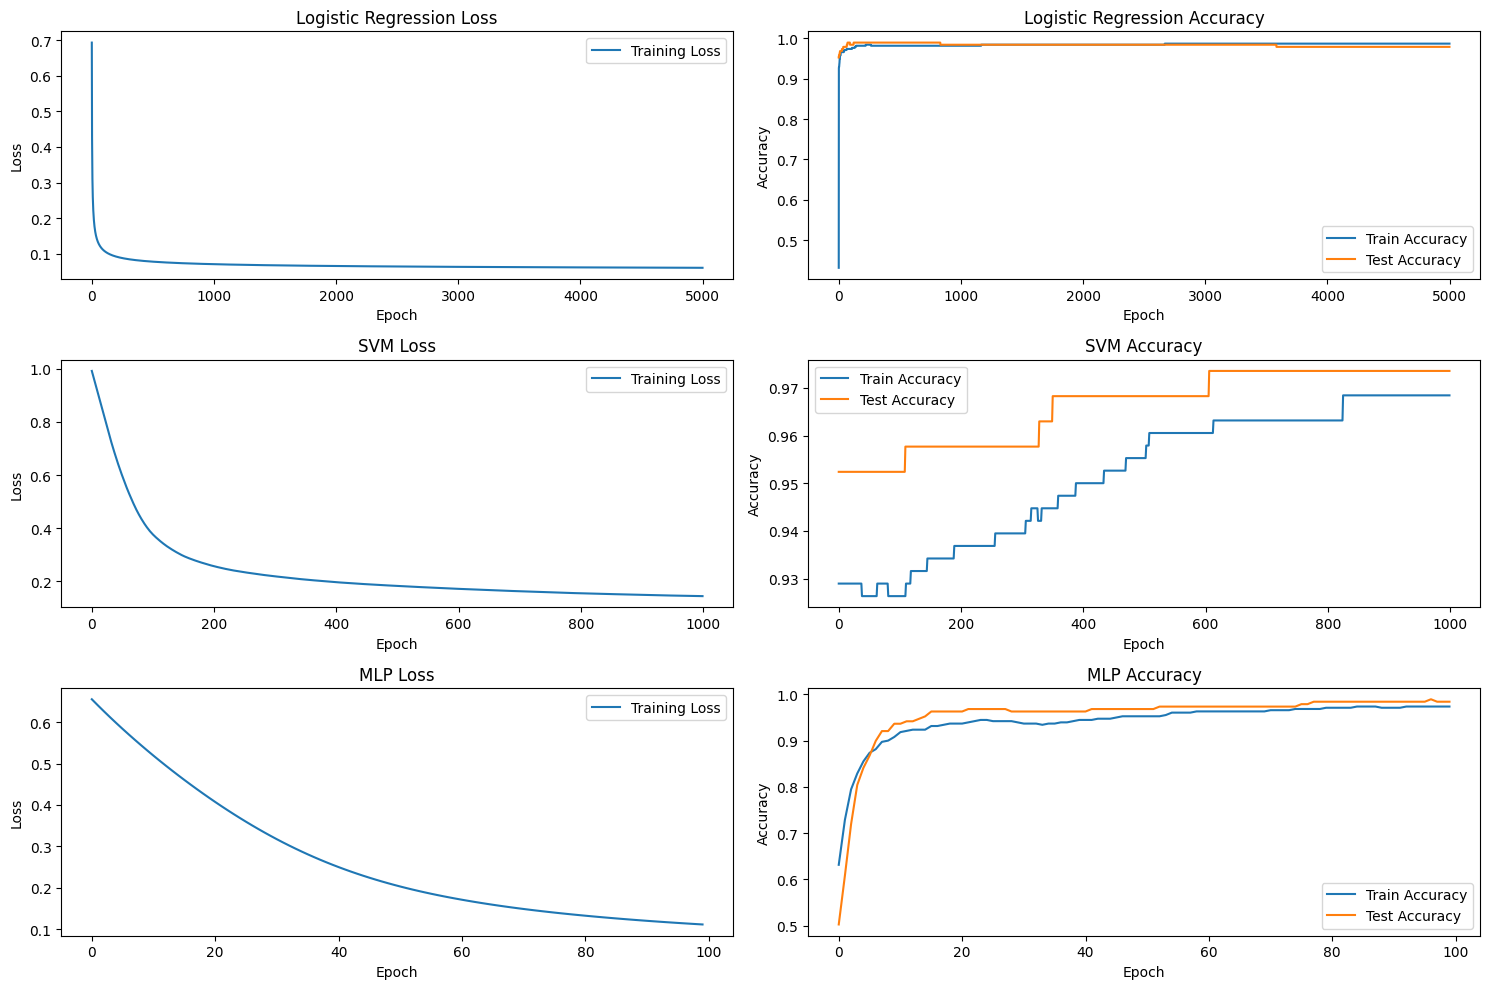

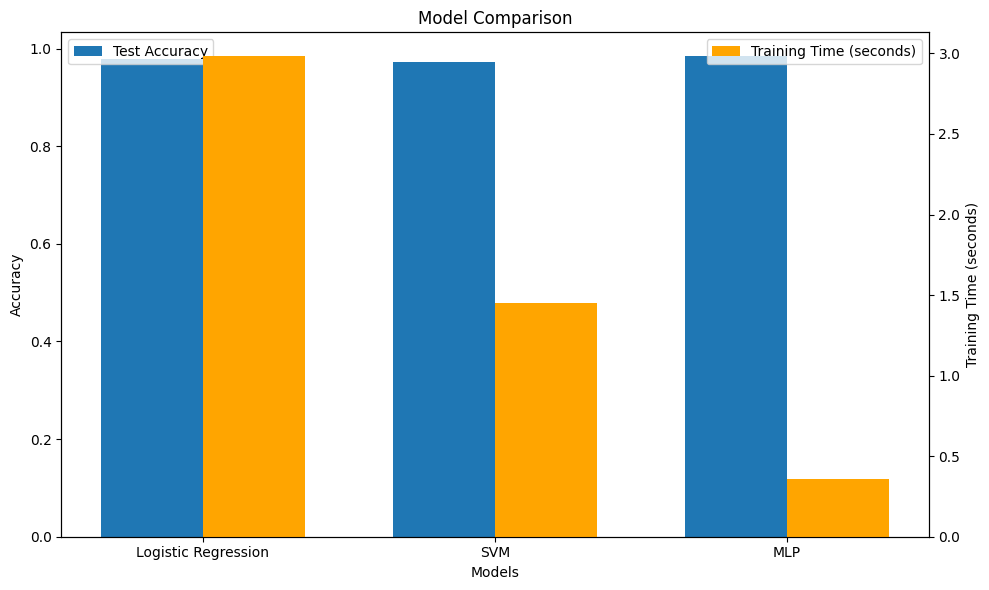


Model Comparison:
Model                Test Accuracy   Training Time (s)   
-------------------- --------------- --------------------
Logistic Regression  0.9788       2.98
SVM                  0.9735       1.45
MLP                  0.9841       0.36


In [15]:
## run this cell to train the models and get the comparison results
if __name__ == "__main__":
    main()